# ML Design Pattern: Repeatable Splitting


## Reproducible ML: Maybe you shouldn't be using train_test_split

In [1]:
# dependencies
# ! pip install farmhash pandas

In [2]:
# !pip install nb_black

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# import the libraries
import pandas as pd

# generate the first DataFrame
X_1 = pd.DataFrame(data={"variable": np.random.normal(size=1000)})

# apply the train-test split
X_1_train, X_1_test = train_test_split(X_1, test_size=0.2, random_state=42)

# add new observations to the DataFrame
X_2 = pd.concat(
    [X_1, pd.DataFrame(data={"variable": np.random.normal(size=500)})]
).reset_index(drop=True)

# again, apply the train-test split to the updated DataFrame
X_2_train, X_2_test = train_test_split(X_2, test_size=0.2, random_state=42)

# see what is the overlap of indices
print(f"Train set: {len(set(X_1_train.index).intersection(set(X_2_train.index)))}")
print(f"Test set: {len(set(X_1_test.index).intersection(set(X_2_test.index)))}")

Train set: 669
Test set: 59


<IPython.core.display.Javascript object>

In [5]:
import farmhash

<IPython.core.display.Javascript object>

In [6]:
airport = ["DTW", "LBB", "SNA", "MSO", "ANC", "PIT", "PWM", "BNA"]

import random

SEED = 42
RECORDS = 100000
BUCKETS = 10

random.seed(SEED)
a = [(i, random.choice(airport)) for i in range(RECORDS)]

df = pd.DataFrame(a, columns=["id", "airport"])

df["hash_airport"] = df["airport"].apply(lambda x: farmhash.hash64(x))
df["hash_id"] = df["id"].apply(lambda x: farmhash.hash64(str(x)))

df["airport_bucket_10"] = df["hash_airport"].apply(lambda x: abs(x % BUCKETS))
df["id_bucket_10"] = df["hash_id"].apply(lambda x: abs(x % BUCKETS))
df.head()

,id,airport,hash_airport,hash_id,airport_bucket_10,id_bucket_10
0,0,LBB,6290192273091124709,15198969275252572735,9,5
1,1,DTW,8485400555133853543,9304157803607034849,3,9
2,2,ANC,3769719083775059508,6920640749119438759,8,9
3,3,MSO,3704558892068952737,11991475895402502921,7,1
4,4,MSO,3704558892068952737,14526854387307260543,7,3


<IPython.core.display.Javascript object>

In [7]:
print(f"Expected = {int(RECORDS*0.1)}")
df[df[["airport_bucket_10", "id_bucket_10"]] >= 9][
    ["airport_bucket_10", "id_bucket_10"]
].count()

Expected = 10000


airport_bucket_10    37871
id_bucket_10          9979
dtype: int64

<IPython.core.display.Javascript object>

In [8]:
import seaborn as sns

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='airport_bucket_10', ylabel='Count'>

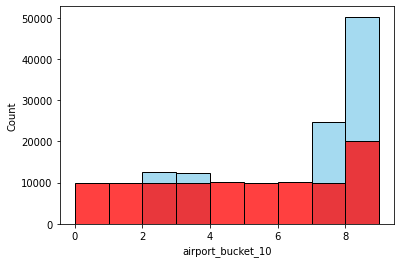

<IPython.core.display.Javascript object>

In [9]:
sns.histplot(
    data=df,
    x="airport_bucket_10",
    color="skyblue",
    label="airport",
    bins=10,
    binwidth=1,
)
sns.histplot(data=df, x="id_bucket_10", color="red", label="id", bins=10, binwidth=1)

In [10]:
def hashed_train_test_split(df, index_col, test_size=0.2):
    """
    Train-test split based on the hash of the unique identifier.
    """
    test_index = df[index_col].apply(lambda x: crc32(np.int64(x)))
    test_index = test_index < test_size * 2 ** 32

    return df.loc[~test_index], df.loc[test_index]

<IPython.core.display.Javascript object>

In [11]:
# create an index column (should be immutable and unique)
X_1 = X_1.reset_index(drop=False)
X_2 = X_2.reset_index(drop=False)

# apply the improved train-test split
X_1_train_hashed, X_1_test_hashed = hashed_train_test_split(X_1, "index")
X_2_train_hashed, X_2_test_hashed = hashed_train_test_split(X_2, "index")

# see what is the overlap of indices
print(
    f"Train set: {len(set(X_1_train_hashed.index).intersection(set(X_2_train_hashed.index)))}"
)
print(
    f"Test set: {len(set(X_1_test_hashed.index).intersection(set(X_2_test_hashed.index)))}"
)

# Train set: 800
# Test set: 200

Train set: 800
Test set: 200


<IPython.core.display.Javascript object>

In [12]:
from zlib import crc32


def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xFFFFFFFF < test_ratio * 2 ** 32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

<IPython.core.display.Javascript object>

### Problem Statement


- It is rare that rows are independent which could lead to data leakage, e.g. predicting flight delays -- need to make sure all information about a single day is in the training set (or testing set)
- We want to ensure certain splits of the data always fall in training or test
- Random seeds are not portable across languages or frameworks
  - imagine you want to put a model into production and your engineer wants to recode it in Java or another language for performance reasons. You might struggle to reproduce the results
  - we want lightweight, repeatrable splitting of the data which works regardless of language or random seeds and ensure correlated rows fall into the same split
  - your colleague might forget to use a random seed or use their favourite (mine is 42 :) ), don't leave it to chance and add another place for divergence
  
- How can you design your split in order to make sure some values are only in the training or test set? Use hashing

"To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set."



### What is the problem with train_test_split?

Randomly shuffles the data.

"Aha! But I always set the random seed so it is reproducible" you might say. Fair point. This certainly improves the situation. However, not for all cases, particularly if you add new data to your dataset an retrain your model. 


### When might train_test_split not be appropriate?

- If you add new data
  - training the model on original data + new data
  - if you are getting your source data from an evolving source and want to reproducibly sample from it
- Of you can't guarantee the ording of datapoints (or filepaths) between training runs
- If there is the possibility of data leakage
  - ie. if you have correlated rows (e.g. airline lateness dataset)
  - "For example, if you are training a model to predict flight delays, the arrival delays of flights on the same day will be highly correlated with each other. This is called leakage, and it is an important problem to avoid when doing machine learning."
- If you have large out of memory datasets
- If your production code will be rewritten in another language -- you cannot guarantee the random seed in another language will produce the same results. This might make it hard to debug and validate the same results in the new code
  - can also lead to difficult to catch bugs if in one part of the code you use sklearn's random seed and other places you use the inbuilt random module functionality.
  
Hashing is deterministic and will return the same result each time


### What are the consequences of using random seed when retraining the model?
- difficult to debug
- data will be shuffled and in different splits. Makes it difficult to accurately compare training runs


### When might hashing be unecessary?

- standard timeseries data: just order your dataset and split
- simple 'one-off' model training on 'small' datasets that easily fit in memory --> this is why it is the defacto method for most tutorials. In the real-world you need to consider whether this is always appropriate


### Conclusion

Should you go and always use hashing for train/test splits. Probably not. Using random seeds with `train_test_split()` method can be ok for one off training (although bear in mind it shuffles the data which might not work for timeseries data).

However, like with many things in ML splitting the data is nuanced and can have undesired effects further down the line. Make sure you make a deliberate choice on the most appropriate method.


I am proposing hashing as an alternative which might be more appropriate in certain situations. Should you use hashing for everything? No. But at least consider whether it is a better approach, particularly if you are retraining you model on old and new data.

In [1]:
import os

In [3]:
import glob

for file in glob.glob(
    "/Users/jnes/tensorflow_datasets/imdb_reviews/plain_text/1.0.0/*"
):
    print(file)

/Users/jnes/tensorflow_datasets/imdb_reviews/plain_text/1.0.0/features.json
/Users/jnes/tensorflow_datasets/imdb_reviews/plain_text/1.0.0/dataset_info.json
/Users/jnes/tensorflow_datasets/imdb_reviews/plain_text/1.0.0/imdb_reviews-train.tfrecord-00000-of-00001
/Users/jnes/tensorflow_datasets/imdb_reviews/plain_text/1.0.0/imdb_reviews-unsupervised.tfrecord-00000-of-00001
/Users/jnes/tensorflow_datasets/imdb_reviews/plain_text/1.0.0/label.labels.txt
/Users/jnes/tensorflow_datasets/imdb_reviews/plain_text/1.0.0/imdb_reviews-test.tfrecord-00000-of-00001


In [4]:
import os

for file in os.listdir(
    "/Users/jnes/tensorflow_datasets/imdb_reviews/plain_text/1.0.0/"
):
    print(file)

features.json
dataset_info.json
imdb_reviews-train.tfrecord-00000-of-00001
imdb_reviews-unsupervised.tfrecord-00000-of-00001
label.labels.txt
imdb_reviews-test.tfrecord-00000-of-00001


### Solution

- use hashing
- deterministic instead of probabilistic

### Why farmhash?

- Performance considerations
- [Understanding hashing functions](https://github.com/google/farmhash/blob/master/Understanding_Hash_Functions)
- [note around order of ABS and MOD](https://mentin.medium.com/be-careful-with-abs-function-8e91c78715d5)
- Implemented consistently in C++ (and hence: Java or Python) and in BigQuery SQL.

You could use another library such as `hashlib` using the md5 algorithm as suggested [in the Hands on with sklearn book](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb). However, I find this implementation unnecessarily verbose.


#### Order of operations

Note that we do the modulo first, and then the absolute value: 
```sql
CREATE TEMPORARY FUNCTION hashed ( 
    airport STRING , numbuckets INT64 
) AS ( 
    ABS ( MOD ( FARM_FINGERPRINT ( airport ), numbuckets )) 
); 
```

The order of ABS , MOD , and FARM_FINGERPRINT in the preceding snippet is important because the range of INT64 is not symmetric. Specifically, its range is between –9,223,372,036,854,775,808 and 9,223,372,036,854,775,807 (both inclusive). So, if we were to do: 

```sql
ABS ( FARM_FINGERPRINT ( airport )) 
```

we would run into a rare and likely unreproducible overflow error if the FARM_FINGERPRINT operation happened to return –9,223,372,036,854,775,808 since its absolute value can not be represented using an INT64! 

---
#### Cryptographic hash

What makes the Hashed Feature lossy is the modulo part of the implementation. What if we were to avoid the modulo altogether? After all, the farm fingerprint has a fixed length (an INT64 is 64 bits), and so it can be represented using 64 feature values, each of which is 0 or 1. This is called binary encoding . However, binary encoding does not solve the problem of out-of-vocabulary inputs or cold start (only the problem of high cardinality). In fact, the bitwise coding is a red herring. If we don’t do a modulo, we can get a unique representation by simply encoding the three characters that form the IATA code (thus using a feature of length 3*26=78). The problem with this representation is immediately obvious: airports whose names start with the letter O have nothing in common when it comes to their flight delay characteristics the encoding has created a spurious correlation between airports that start with the same letter. The same insight holds in binary space as well. Because of this, we do not recommend binary encoding of farm fingerprint values. 

Binary encoding of an MD5 hash will not suffer from this spurious correlation problem because the output of an MD5 hash is uniformly distributed, and so the resulting bits will be uniformly distributed. However, unlike the Farm Fingerprint algorithm, the MD5 hash is not deterministic and not unique it is a one-way hash and will have many unexpected collisions. 

In the Hashed Feature design pattern, we have to use a fingerprint hashing algorithm and not a cryptographic hashing algorithm. This is because the goal of a fingerprint function is to produce a deterministic and unique value. If you think about it, this is a key requirement of preprocessing functions in machine learning, since we need to apply the same function during model serving and get the same hashed value. A fingerprint function does not produce a uniformly distributed output. Cryptographic algorithms such as MD5 or SHA1 do produce uniformly distributed output, but they are not deterministic and are purposefully made to be computationally expensive. Therefore, a cryptographic hash is not usable in a feature engineering context where the hashed value computed for a given input during prediction has to be the same as the hash computed during training, and where the hash function should not slow down the machine learning model. 

"The reason that MD5 is not deterministic is that a “salt” is typically added to the string to be hashed. The salt is a random string added to each password to ensure that even if two users happen to use the same password, the hashed value in the database will be different. This is needed to thwart attacks based on “rainbow tables,” which are attacks that rely on dictionaries of commonly chosen passwords and that compare the hash of the known password against hashes in the database. As computational power has increased, it is possible to carry out a brute-force attack on every possible salt as well, and so modern cryptographic implementations do their hashing in a loop to increase the computational expense. Even if we were to turn off the salt and reduce the number of iterations to one, the MD5 hash is only one way. It won’t be unique."


Lakshmanan, Valliappa,Robinson, Sara,Munn, Michael. Machine Learning Design Patterns (p. 37). O'Reilly Media. Kindle Edition. 

---


### Which column should you hash?

Use a unique identifier. Concatenate columns if this is not possible.

Should not be a field which is used for the model.

If splitting on date, we can still use features extracted from it (e.g. day of week, month etc.), but not the date itself (which makes sense anyway as it would not make sense to use a historical date as a feature for dates in the future).

"We can automate checking whether the label distributions are similar across the three datasets by using the Kolomogorov–Smirnov test: just plot the cumulative distribution functions of the label in the three datasets and find the maximum distance between each pair. The smaller the maximum distance, the better the split."

### Considerations
- what are the gotchas?
- with small datasets you won't have exactly the % split you desire. -- I could do a chart showing how when splitting on ID it eventually trends to the correct split if data is large enough

### Demo

- use fake properties data (to demonstrate hashing of strings)

### Other use cases for hashing

- feature engineering categorical values
- using reproducible subsets of large data for training 

In [24]:
import farmhash

TEST_LENGTH = 1e4

import hashlib

farmhash.hash64(123)

TypeError: argument 1 must be str, not int

In [18]:
%time
for _ in range(int(TEST_LENGTH)):
    farmhash.hash64("abc")

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs


KeyboardInterrupt: 

In [22]:
%time
for _ in range(int(TEST_LENGTH)):
    hashlib.md5("abc")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


TypeError: Unicode-objects must be encoded before hashing